In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme('paper')


import astropy.constants as const
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号
%config InlineBackend.figure_format = 'retina'
# plt.style.use('ggplot')
# plt.rcParams['text.usetex'] = True

from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline   # 三次样条插值
from scipy.signal import find_peaks
from peakutils import baseline

import os
path='./figs/'
os.makedirs(path,exist_ok=True) 

# 理论公式

理论公式借用了 `astropy` 进行了带单位运算， 公式采用自然单位制。

In [2]:
def gamma_out_ratio(theta,omega_in):
    return 1/(1+omega_in/(const.m_e*const.c**2)*(1-np.cos(theta)))

def Klein_Nishin_formula(theta,omega):
    '''
    return d\\sigma/d\\cos(\\theta)
    '''
    
    omega_p_over_omega = gamma_out_ratio(theta,omega)
    diff_cross = np.pi*const.alpha**2/(const.m_e*const.c**2)**2*omega_p_over_omega**2*(omega_p_over_omega+1/omega_p_over_omega-np.sin(theta)**2)
    return (diff_cross*(const.h*const.c)**2).to(u.barn)
Cs137_Energy = 0.662*u.MeV

# 能谱数据处理

### 效率校刻

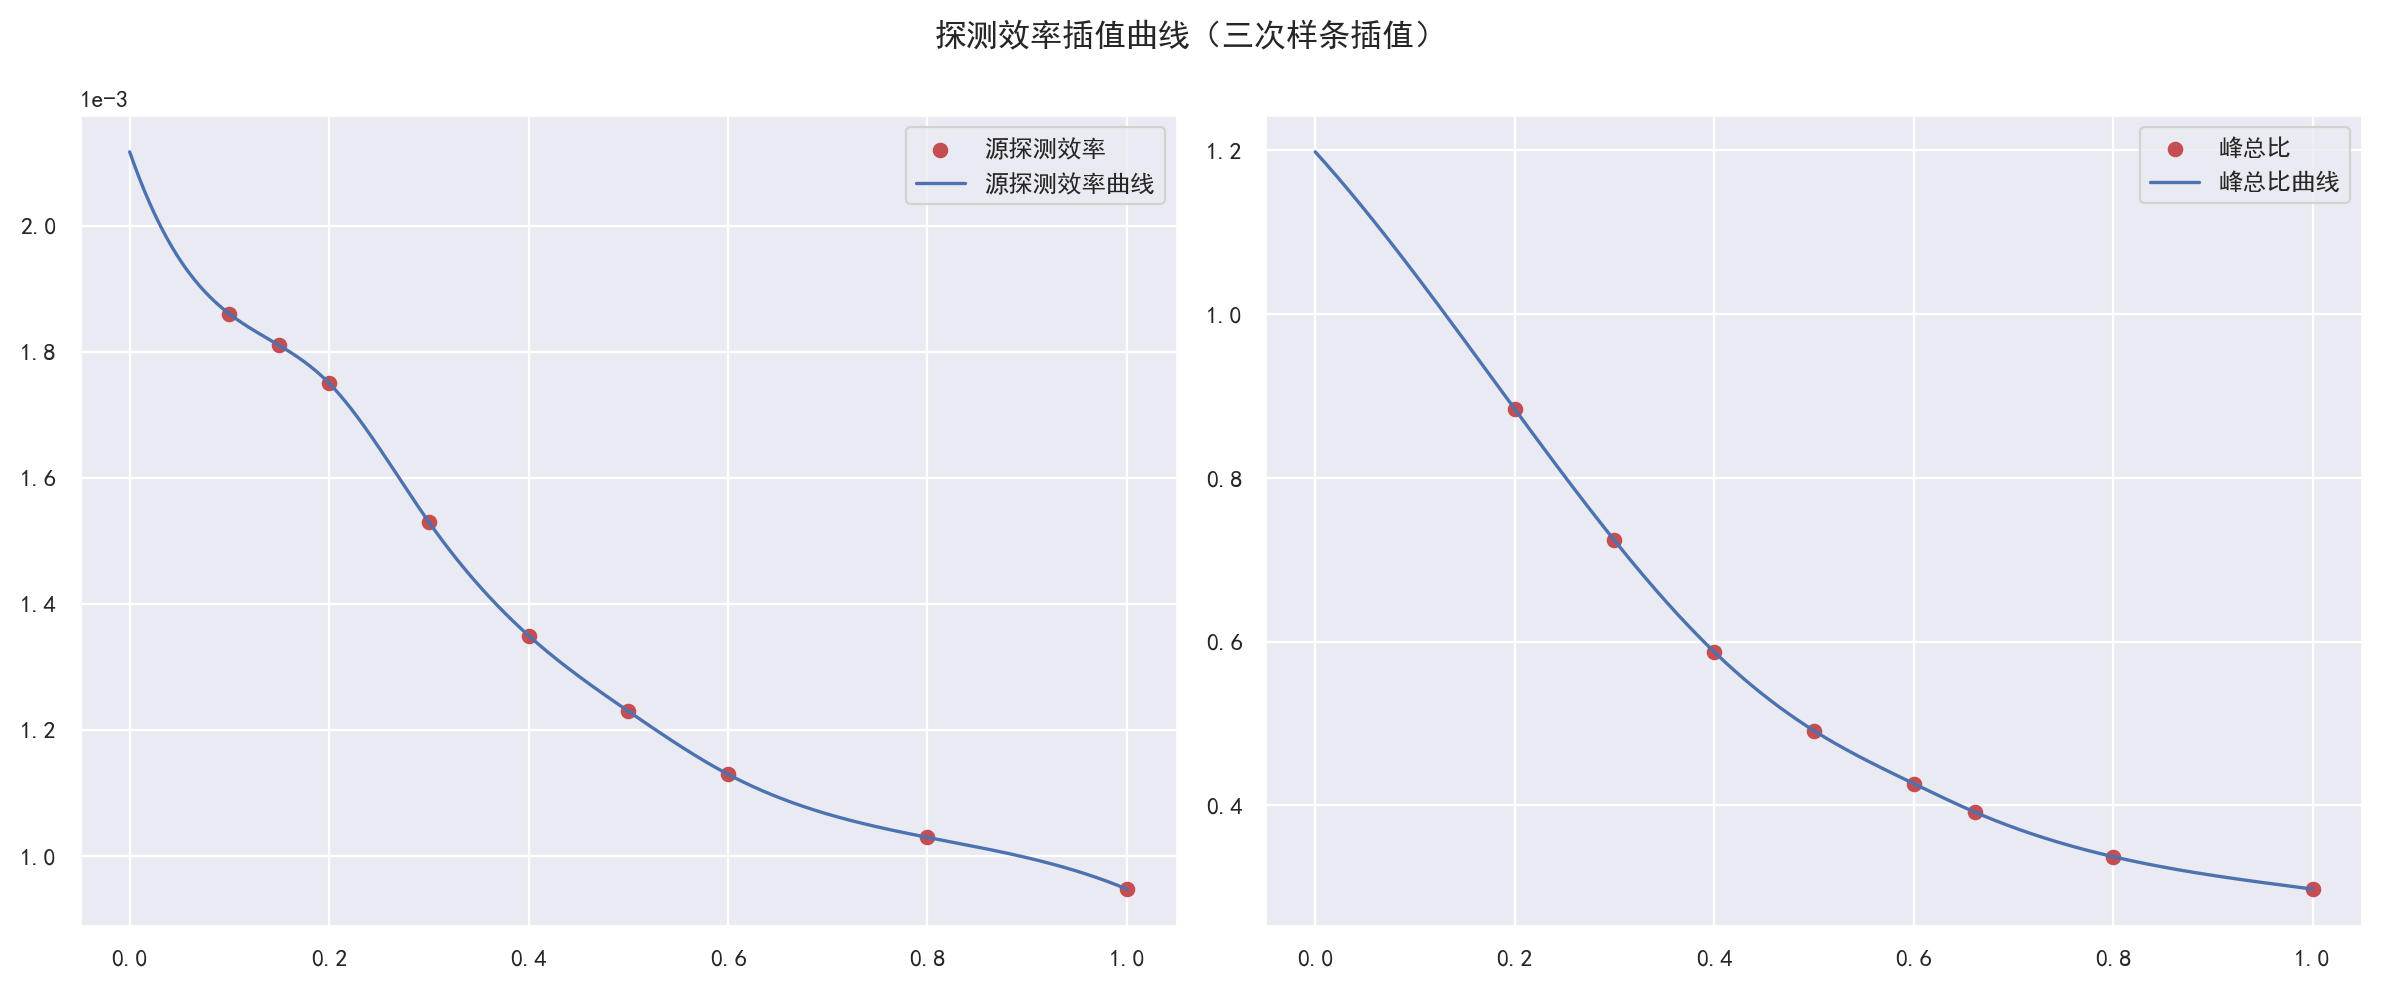

In [3]:
eta_data = pd.read_excel('detector efficience.xlsx',sheet_name='eta')
R_data = pd.read_excel('detector efficience.xlsx',sheet_name='R')

ene_to_eta = CubicSpline(eta_data['E(MeV)'],eta_data['eta(*1e4)'].apply(lambda x:x*1e-4))
ene_to_R = CubicSpline(R_data['E(MeV)'],R_data['R'])
# ene_to_eta = lagrange(eta_data['E(MeV)'],eta_data['eta(*1e4)'].apply(lambda x:x*1e-4))
# ene_to_R = lagrange(R_data['E(MeV)'],R_data['R'])

ene_plot = np.linspace(0,1,1001)
fig,ax=plt.subplots(1,2,figsize = (12,5))
ax[0].scatter(eta_data['E(MeV)'],eta_data['eta(*1e4)'].apply(lambda x:x*1e-4),
              c='r',label = '源探测效率')
ax[0].plot(ene_plot,ene_to_eta(ene_plot),
           c = 'b',label = '源探测效率曲线')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].legend()
ax[1].scatter(R_data['E(MeV)'],R_data['R'],
              c='r',label = '峰总比')
ax[1].plot(ene_plot,ene_to_R(ene_plot),
           c='b',label = '峰总比曲线')
ax[1].legend()
fig.suptitle('探测效率插值曲线（三次样条插值）')
fig.tight_layout()
fig.savefig(path+'efficience_interplo.pdf')

### 数据提取

In [4]:
datapath = './data/'
files = os.listdir(datapath)

txtfiles = []
for file in files:
    _,extension= os.path.splitext(file)
    if extension=='.txt':
        txtfiles.append(file)
txtfiles[:] = [txtfiles[-1]] + txtfiles[:-1]
txtfiles[3] , txtfiles[2] = txtfiles[2] , txtfiles[3]
txtfiles[4] , txtfiles[6] = txtfiles[6] , txtfiles[4]

txtfiles
# txtfiles

['22Nazx_txt.txt',
 '137Cszx_txt.txt',
 '137Cs_120_txt.txt',
 '137Cs_100_txt.txt',
 '137Cs_80_txt.txt',
 '137Cs_60_txt.txt',
 '137Cs_40_txt.txt',
 '137_Cs_20_txt.txt']

In [5]:
datas = [pd.read_csv(datapath+file, sep='\t')['1'].values for file in txtfiles]
_datas_Energy_scale = datas[:2]
_datas_Full_Energy = datas[2:]

### 能量刻度

array([<Axes: >, <Axes: >], dtype=object)

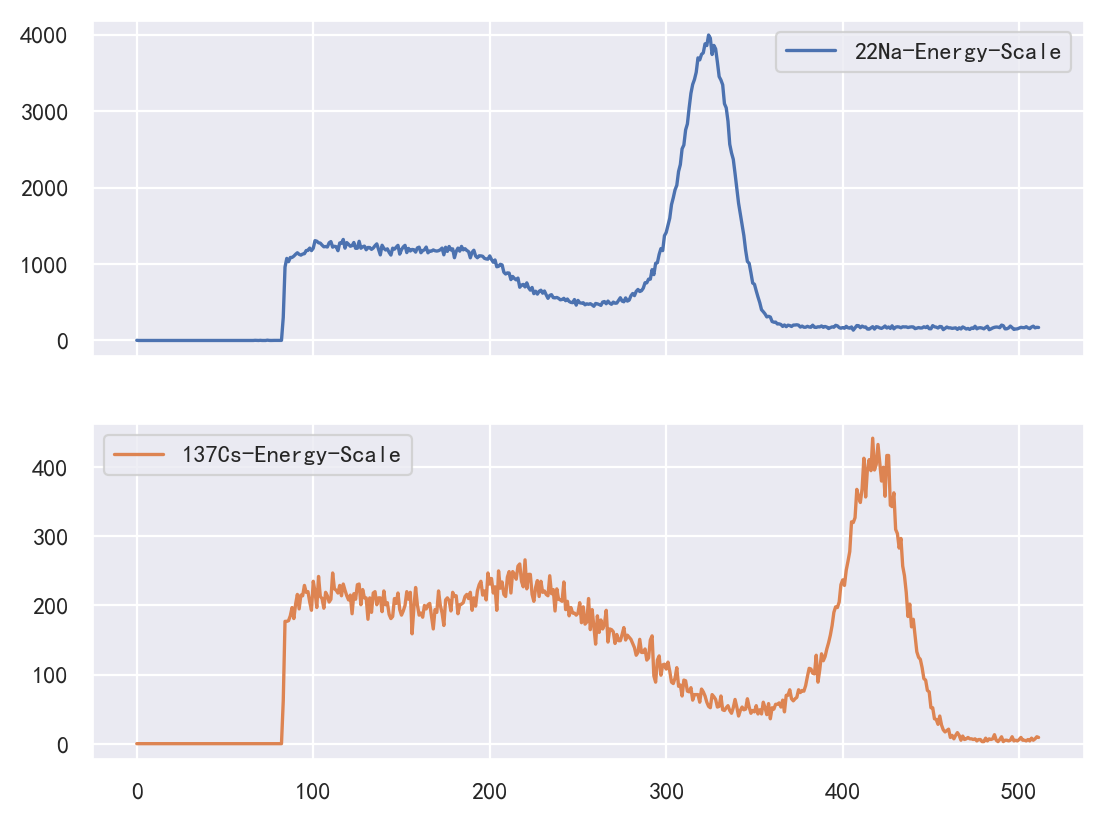

In [6]:
datas_Energy_scale=pd.DataFrame(dict(zip(['22Na-Energy-Scale','137Cs-Energy-Scale'],
                                         _datas_Energy_scale)))
datas_Energy_scale.plot(subplots=True)

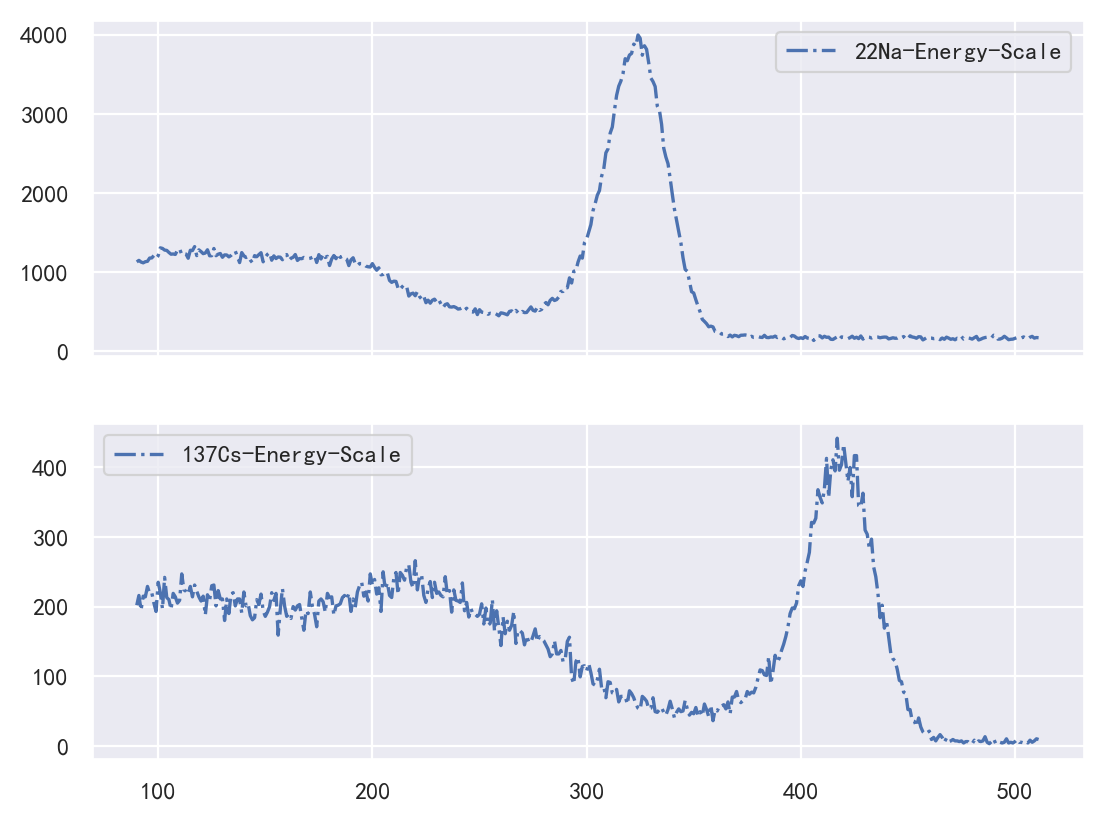

In [7]:
drop1 = 90
datas_Energy_scale = datas_Energy_scale.drop(np.arange(0,drop1,1))
axes = datas_Energy_scale.plot(subplots=True,color='b',style='-.')
fig = axes[0].get_figure()

#### 基线

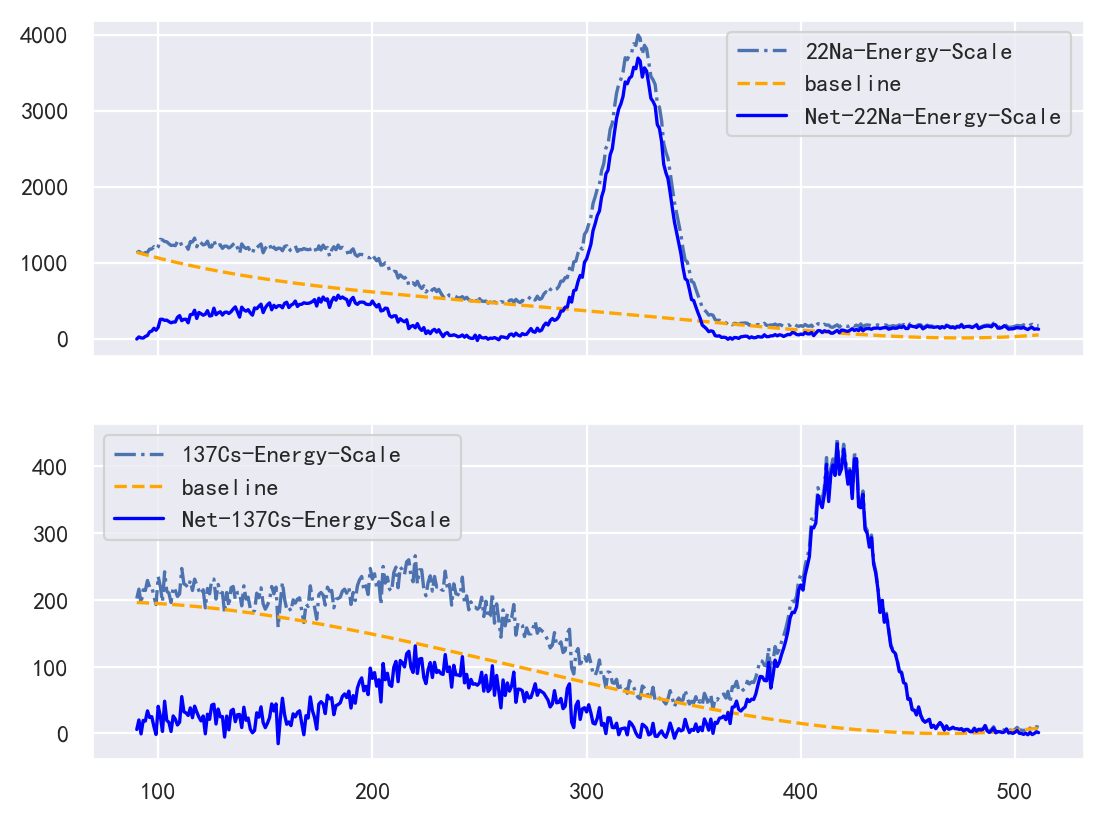

In [8]:
bl1 = baseline(datas_Energy_scale['22Na-Energy-Scale'],
              deg=4)
datas_Energy_scale['Net-22Na-Energy-Scale'] = datas_Energy_scale['22Na-Energy-Scale'].values-bl1
bl2 = baseline(datas_Energy_scale['137Cs-Energy-Scale'],
              deg=3)
datas_Energy_scale['Net-137Cs-Energy-Scale'] = datas_Energy_scale['137Cs-Energy-Scale'].values-bl2

axes[0].plot(datas_Energy_scale.index.values,bl1,color='orange',
             label = 'baseline', linestyle='dashed')
datas_Energy_scale.plot(y='Net-22Na-Energy-Scale',ax=axes[0],color='blue')
axes[1].plot(datas_Energy_scale.index.values,bl2,color='orange',
             label = 'baseline', linestyle='dashed')
datas_Energy_scale.plot(y='Net-137Cs-Energy-Scale',ax=axes[1],color='blue')


for ax in axes:
    le = ax.legend()
    # le.get_texts()[0].set_text('sdf')
fig

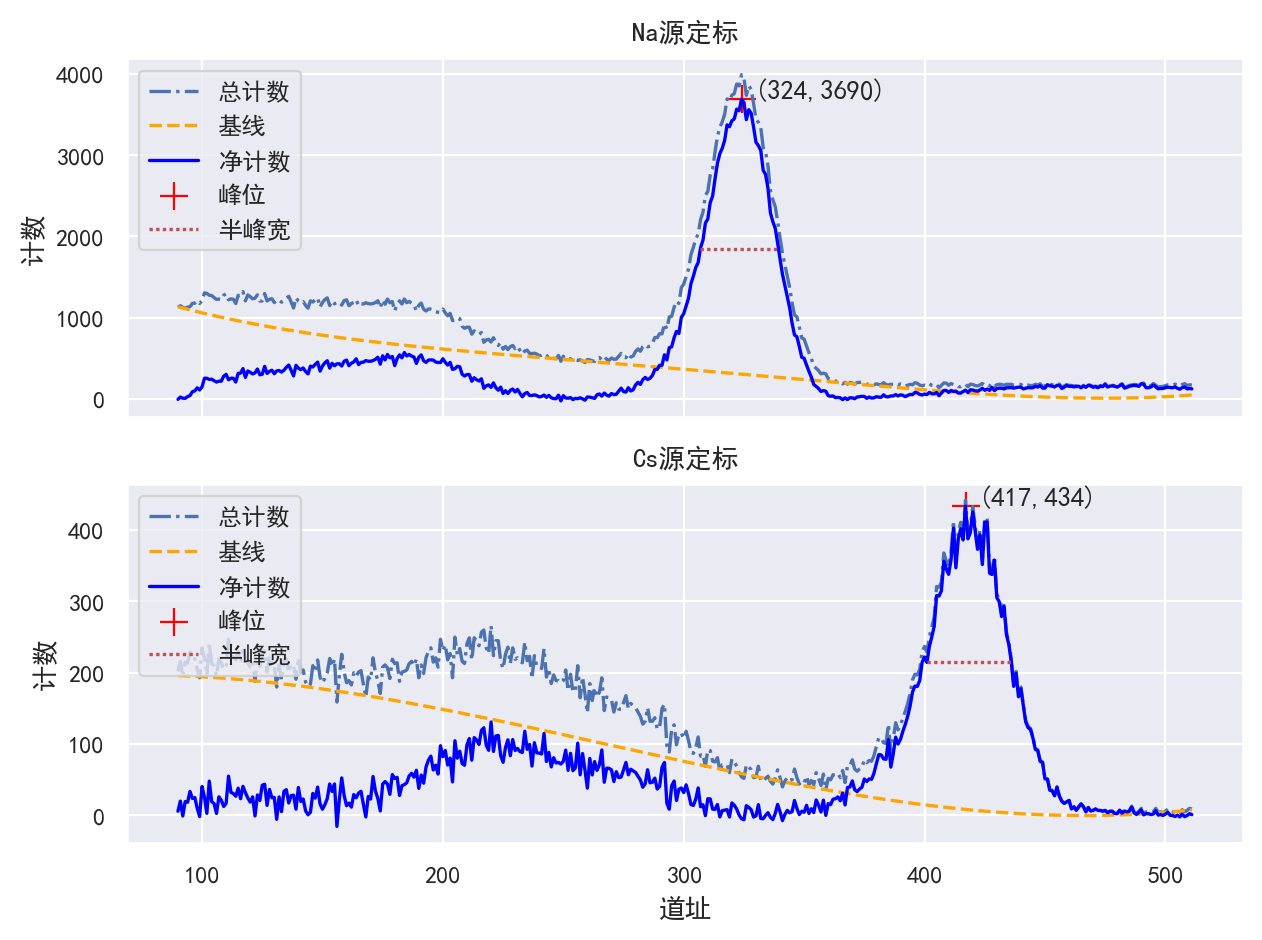

,sourse,peak,width
0,Na,324,32.525339
1,Cs,417,34.949287


In [9]:
# peak1
peaks1,info1 = find_peaks(datas_Energy_scale['Net-22Na-Energy-Scale'],
          height=2000,
          width=30,
          prominence=3000)
sns.scatterplot(datas_Energy_scale.iloc[peaks1],
                x=datas_Energy_scale.index[peaks1],
                y='Net-22Na-Energy-Scale',ax=axes[0],
                label='Peak',color='red',marker='+',s=100)
axes[0].text(datas_Energy_scale.index[peaks1[0]]+5,
              info1['peak_heights'][0],
              f'({datas_Energy_scale.index[peaks1[0]]},{info1['peak_heights'][0]:.0f})')

axes[0].hlines(info1['width_heights'],info1['left_ips']+drop1,info1['right_ips']+drop1,
               linestyle=(0, (1, 1)),label='FWHM',color='r')
# peak2
peaks2,info2 = find_peaks(datas_Energy_scale['Net-137Cs-Energy-Scale'],
          height=200,
          width=30,
          prominence=400)
sns.scatterplot(datas_Energy_scale.iloc[peaks2],
                x=datas_Energy_scale.index[peaks2],
                y='Net-137Cs-Energy-Scale',ax=axes[1],
                label='Peak',color='red',marker='+',s=100)
axes[1].hlines(info2['width_heights'],info2['left_ips']+drop1,info2['right_ips']+drop1,
               linestyle=(0, (1, 1)),label='FWHM',color='r')
axes[1].text(datas_Energy_scale.index[peaks2[0]]+5,
              info2['peak_heights'][0],
              f'({datas_Energy_scale.index[peaks2[0]]},{info2['peak_heights'][0]:.0f})')

for ax in axes:
    le = ax.legend(['总计数','基线','净计数','峰位','半峰宽'],loc='upper left')

axes[1].set_xlabel('道址')

axes[0].set_ylabel('计数')
axes[0].set_title('Na源定标')
axes[1].set_ylabel('计数')
axes[1].set_title('Cs源定标')
fig.tight_layout()
fig.savefig(path+'Energy_Scale.pdf')
display(fig)

ene_sca_result = pd.DataFrame({'sourse':['Na','Cs'],
                       'peak':[datas_Energy_scale.index[peaks1[0]],datas_Energy_scale.index[peaks2[0]]],
                       'width':[info1['widths'][0],info2['widths'][0]]})
display(ene_sca_result)

#### 能量刻度结果

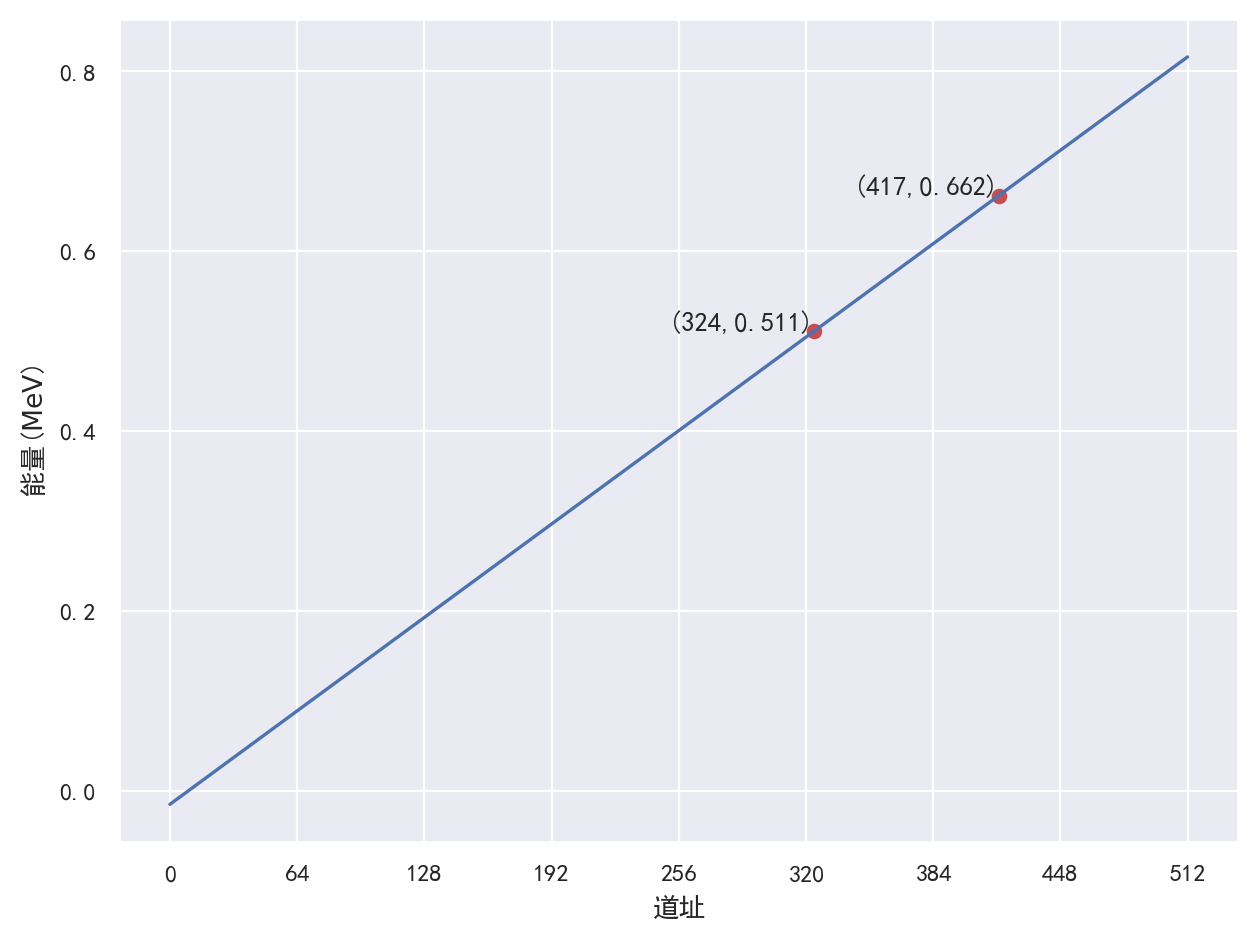

In [10]:
Ene = [0.511,0.662]
dao = ene_sca_result['peak']
dao_to_Ene = lagrange(dao,Ene)
x = np.linspace(0,512,512)
plt.plot(x,dao_to_Ene(x),'b')
plt.scatter(dao,Ene,c='r')
plt.text(dao[0],Ene[0],f'({dao[0]},{Ene[0]})',ha='right')
plt.text(dao[1],Ene[1],f'({dao[1]},{Ene[1]})',ha='right')
plt.xticks(np.linspace(0,512,9))
plt.xlabel('道址')
plt.ylabel(r'能量($\mathrm{MeV}$)')
plt.tight_layout()
plt.grid(True)
plt.savefig(path+'calibration.pdf')
plt.show()

### 能谱数据

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

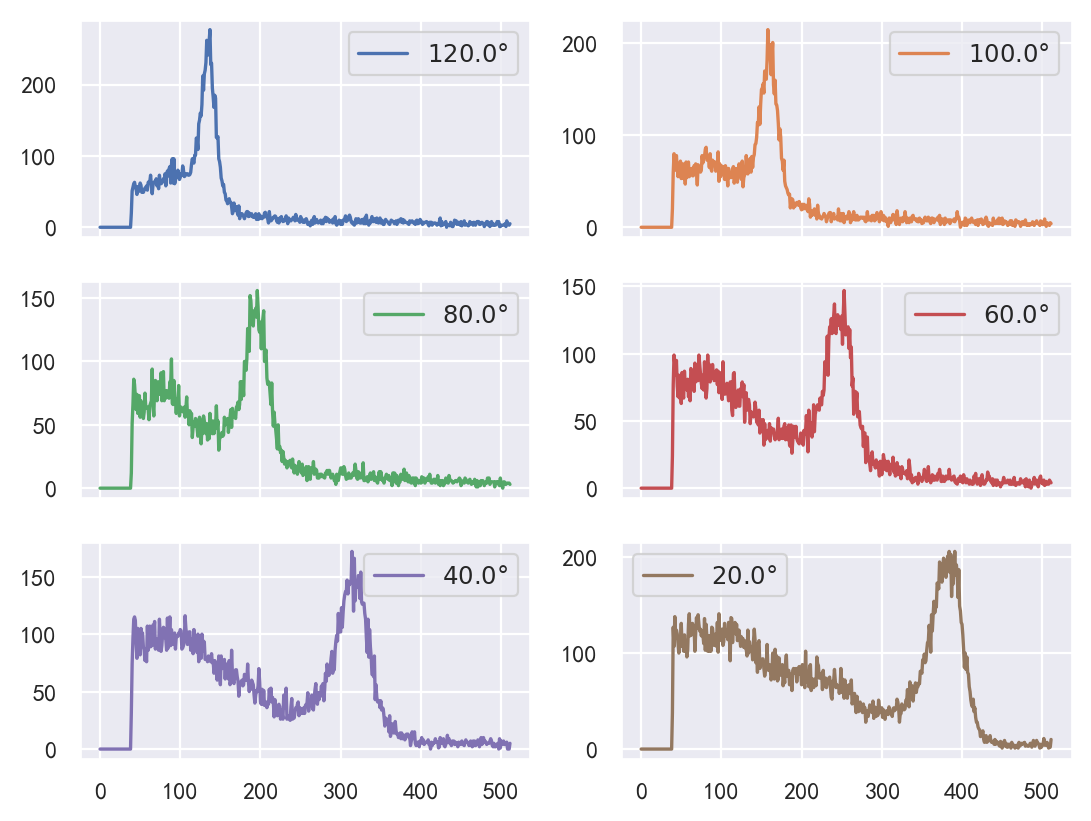

In [11]:
datas_Full_Energy=pd.DataFrame(dict(zip([fr'${i}\degree$' for i in np.linspace(120,20,6)],
                                         _datas_Full_Energy)))
datas_Full_Energy.plot(subplots=True,layout=[3,2])

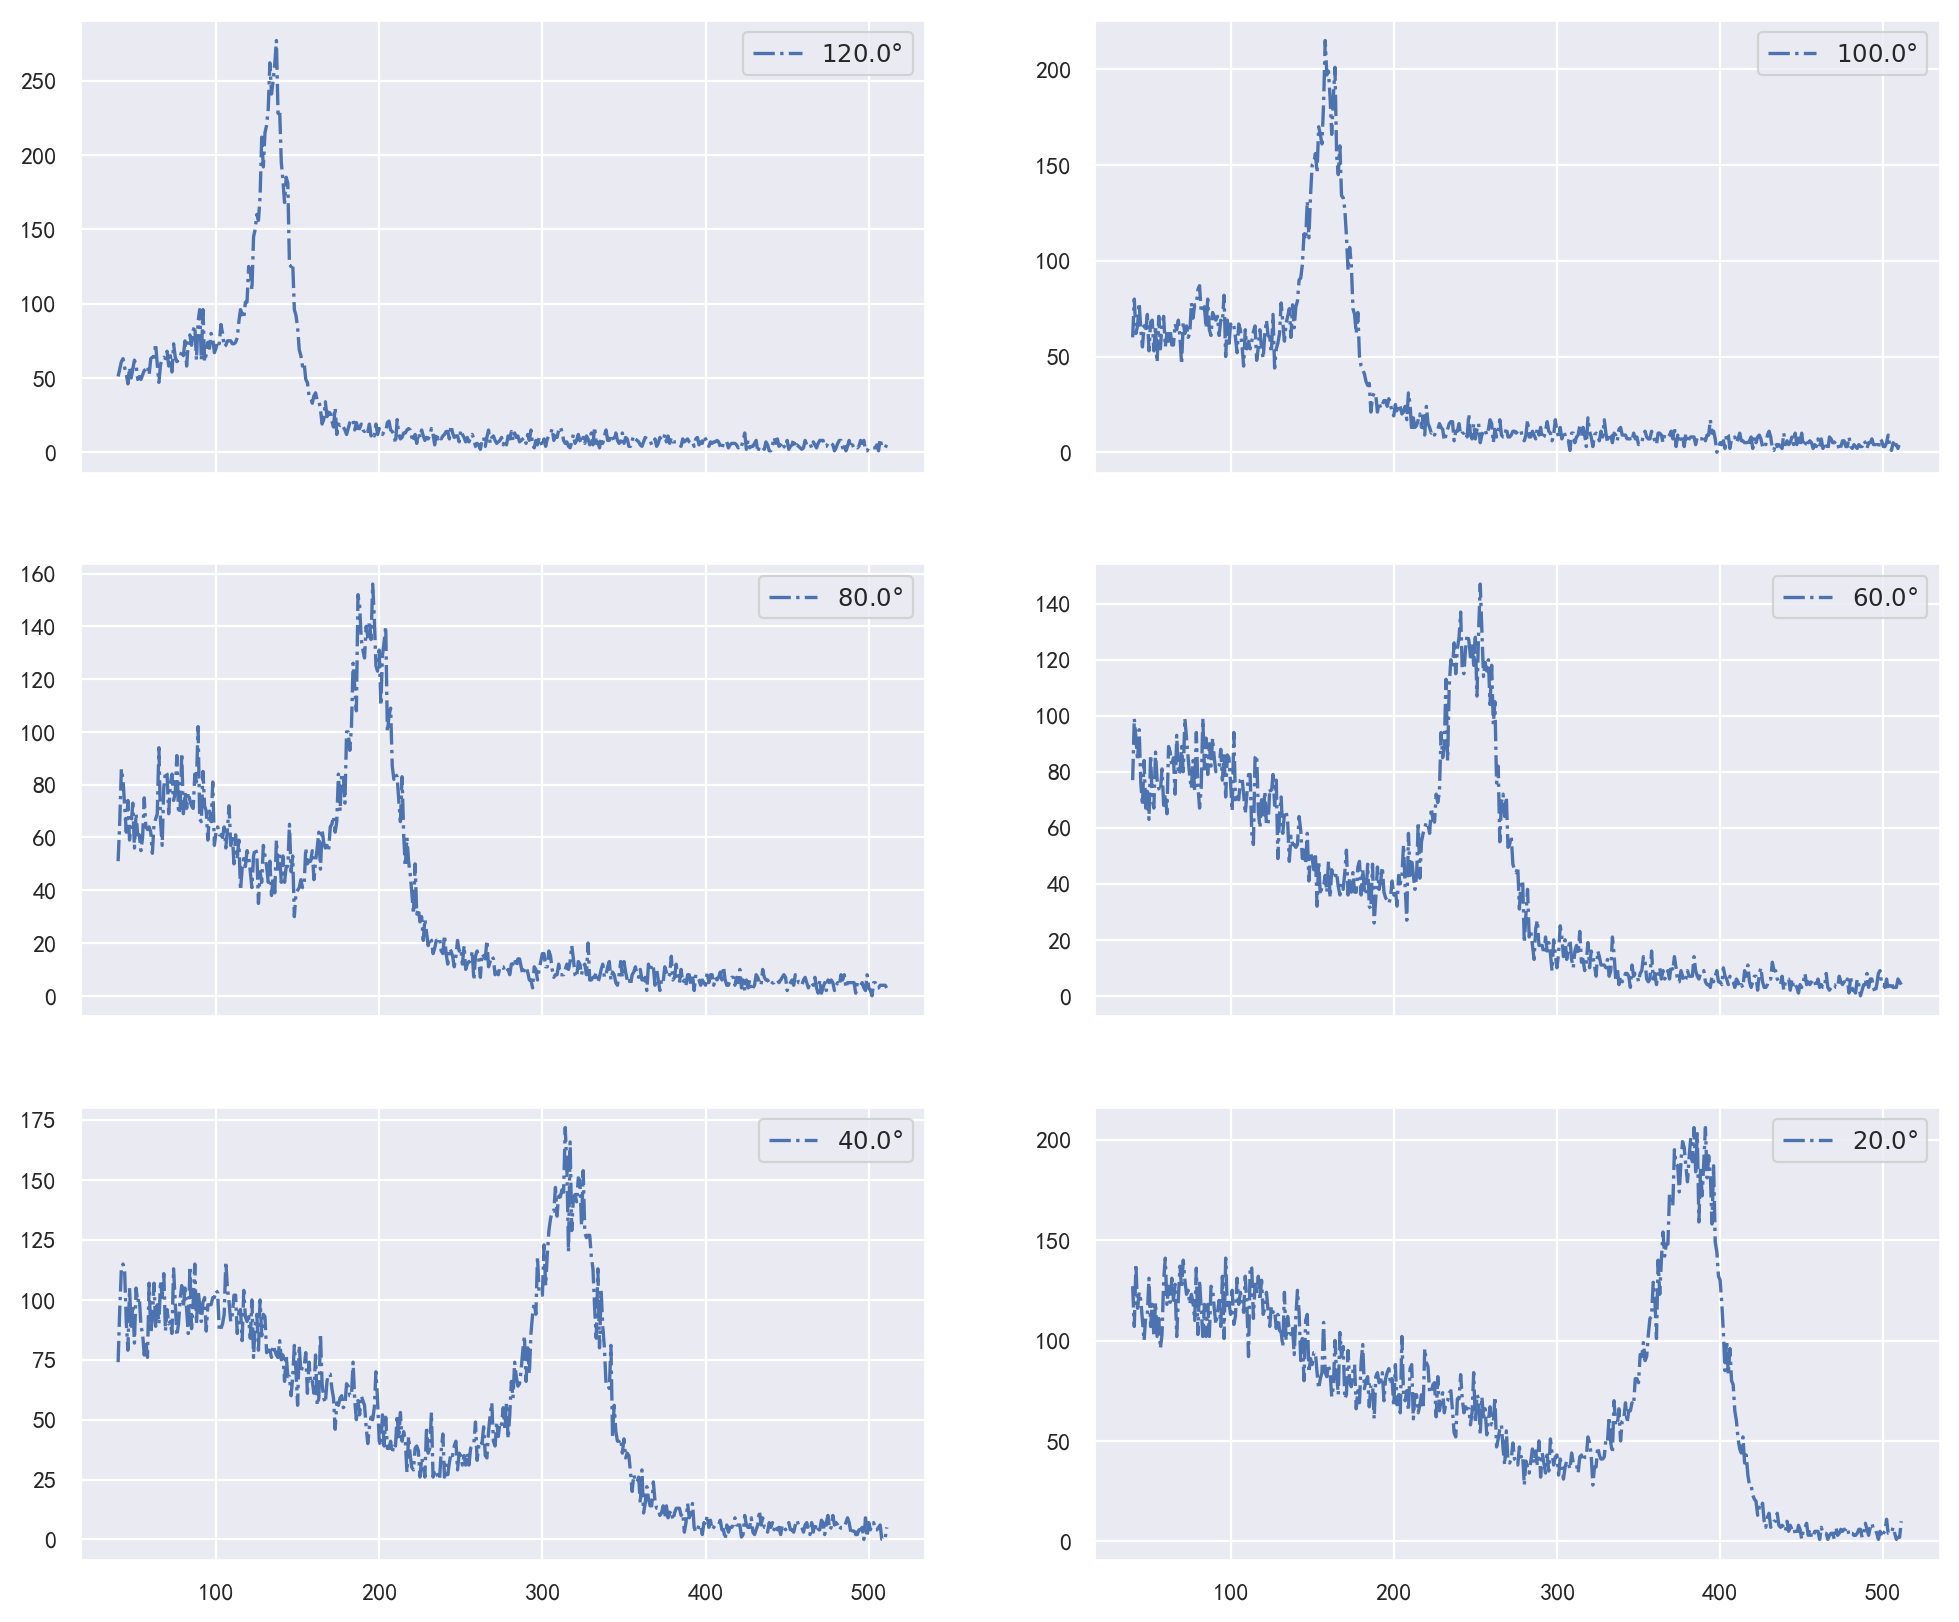

In [12]:
drop2 = 40
datas_Full_Energy = datas_Full_Energy.drop([i for i in range(drop2)])
FE_axes = datas_Full_Energy.plot(subplots=True,layout=[3,2],figsize=(12,10),color='b',style='-.')
FE_axes = FE_axes.flatten()
FE_fig = FE_axes[0].get_figure()

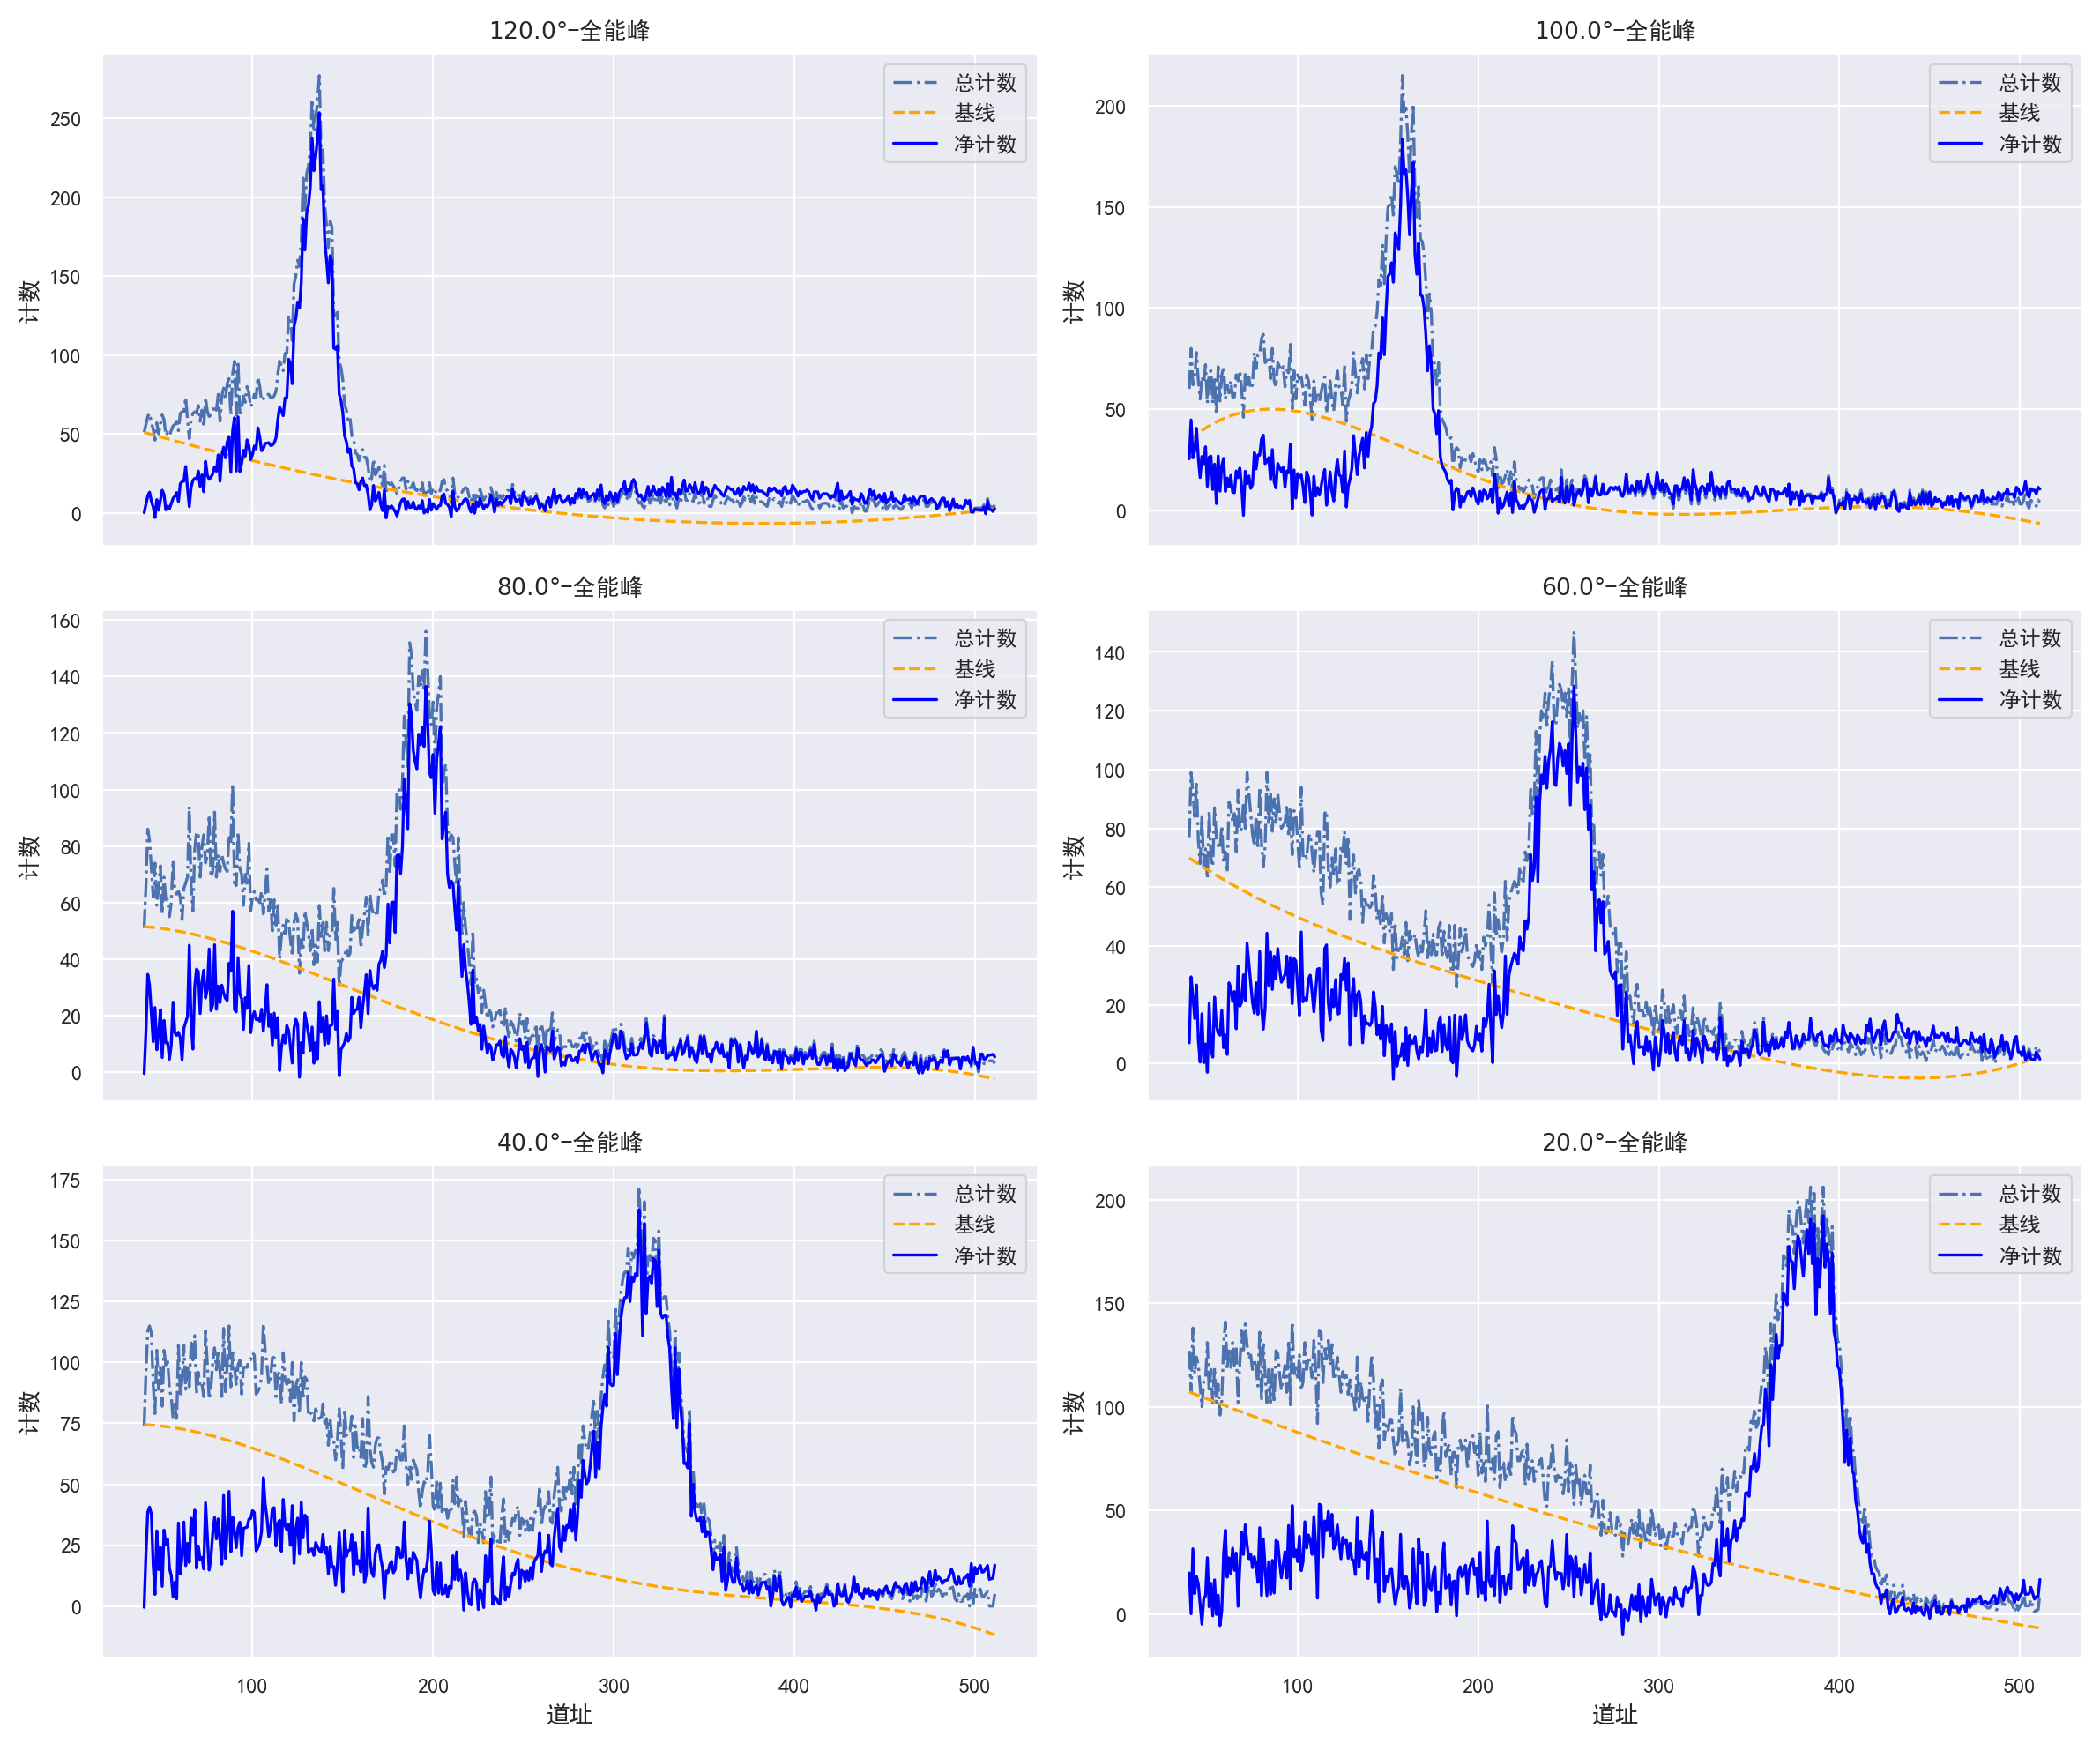

In [13]:
degs = [3,5,4,4,4,2]
bls =[baseline(datas_Full_Energy[column],deg = deg) for column,deg in \
      zip(datas_Full_Energy.columns.values,degs)]

for ax,bl,column in zip(FE_axes,bls,datas_Full_Energy.columns.values):
    ax.plot(datas_Full_Energy.index,bl,label = 'baseline',linestyle='dashed',color='orange')
    datas_Full_Energy['Net'+column] = datas_Full_Energy[column]-bl
    ax.plot(datas_Full_Energy.index,datas_Full_Energy['Net'+column],
            label='Net'+column,color = 'blue')


for ax,column in zip(FE_axes,datas_Full_Energy.columns[:6]):
    ax.legend(['总计数','基线','净计数'])
    ax.set_title(column+'-全能峰')
    ax.set_ylabel('计数')

FE_axes[-1].set_xlabel('道址')
FE_axes[-2].set_xlabel('道址')

    # le.get_texts()[0].set_text('sdf')
FE_fig.tight_layout()
FE_fig.savefig(path+'Full_Energy_Peak-Baseline.pdf')
FE_fig

In [14]:
Net_Full_Energy = datas_Full_Energy[datas_Full_Energy.columns[6:]]
Net_Full_Energy

,Net$120.0\degree$,Net$100.0\degree$,Net$80.0\degree$,Net$60.0\degree$,Net$40.0\degree$,Net$20.0\degree$
40,0.052577,25.408092,-0.503733,7.084282,-0.500677,19.872990
41,5.376182,44.649984,14.548187,29.496102,21.539952,0.209166
42,10.698955,25.914829,34.604121,22.904827,38.585696,31.544940
43,13.020895,29.202320,30.664021,15.310486,40.636498,9.880313
44,7.342002,40.512154,20.727842,26.713107,37.692301,18.215283
...,...,...,...,...,...,...
507,7.224266,9.833125,5.858961,1.453677,16.698416,10.126001
508,2.085653,10.001999,6.002121,1.231582,10.967173,7.274446
509,1.945892,8.171935,6.148910,4.005054,11.240379,8.422490
510,0.804983,11.342883,6.299374,2.774061,11.518090,8.570131


,angle,peaks,area
0,120.0,137,7505.857205
1,100.0,158,5580.392169
2,80.0,196,5190.572381
3,60.0,253,5171.011000
4,40.0,314,8113.086885
5,20.0,391,9413.892215


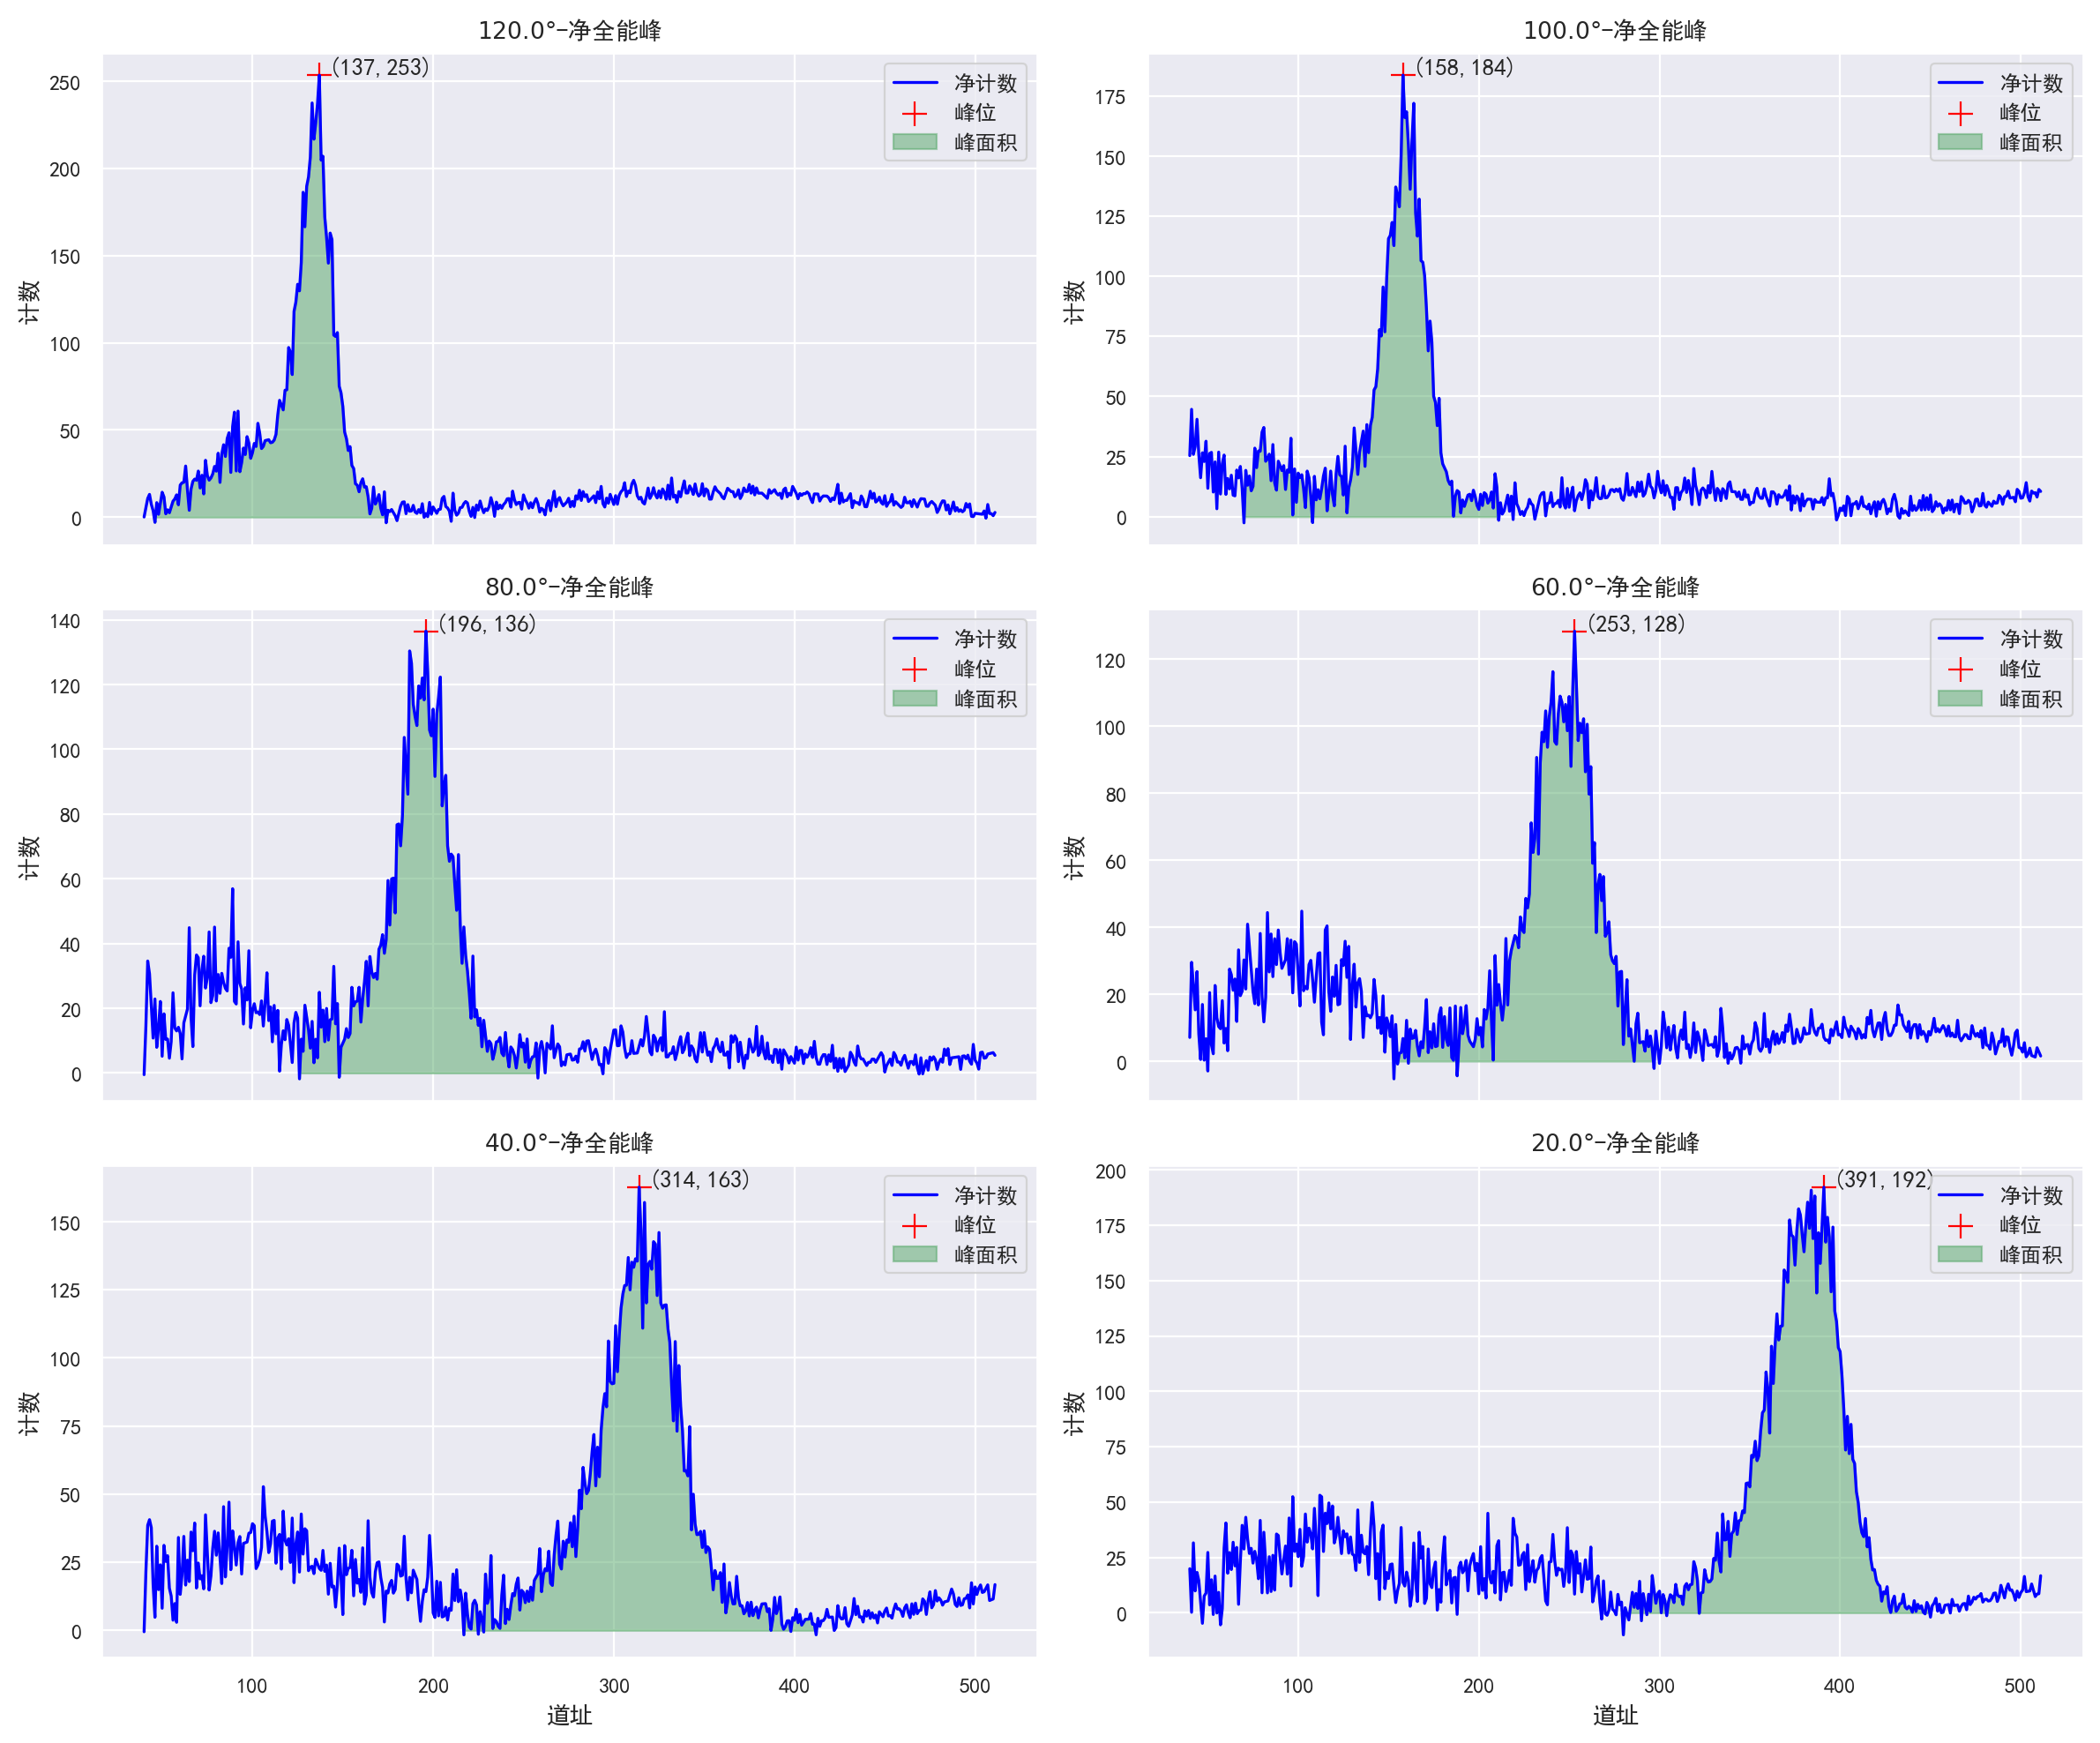

In [22]:
NET_axes = Net_Full_Energy.plot(subplots=True,layout=[3,2],figsize=(12,10),color='blue')
NET_axes = NET_axes.flatten()
heights = [100]*6
prominences = [200,150,120,120,140,160]


areas = []
peak_chennels = []
for ax,column,height,prominence in zip(NET_axes,Net_Full_Energy.columns,heights,prominences):
    peaks,info = find_peaks(Net_Full_Energy[column],
            height=height,
            prominence=prominence)
    peak_chennels.append(Net_Full_Energy.index[peaks[0]])
    sns.scatterplot(Net_Full_Energy.iloc[peaks],
                    x=Net_Full_Energy.index[peaks],
                    y=column,ax=ax,
                    label='Peak',color='red',marker='+',s=100)
    ax.text(Net_Full_Energy.index[peaks[0]]+5,
                 info['peak_heights'][0],
                 f'({Net_Full_Energy.index[peaks[0]]},{info['peak_heights'][0]:.0f})')
    low_index = Net_Full_Energy.index[info['left_bases']][0]
    high_index = Net_Full_Energy.index[info['right_bases']][0]
    fill_interval = np.arange(low_index,high_index,1)
    ax.fill_between(fill_interval,
                    0,
                    Net_Full_Energy[column][fill_interval],
                    color='g',alpha=0.5,label='Peak Area')
    areas.append(np.trapz(Net_Full_Energy[column][fill_interval]))

for ax,column in zip(NET_axes,datas_Full_Energy.columns[:6]):
    ax.legend(['净计数','峰位','峰面积'])
    ax.set_title(column+'-净全能峰')
    ax.set_ylabel('计数')

NET_axes[-1].set_xlabel('道址')
NET_axes[-2].set_xlabel('道址')


FE_result = pd.DataFrame({'angle':np.linspace(120,20,6),
                          'peaks':peak_chennels,
                          'area':areas})

NET_fig = NET_axes[0].get_figure()
NET_fig.tight_layout()
NET_fig.savefig(path+'Full_Energy_Peak.pdf')
FE_result

In [23]:
dis = 226 #mm
S_dect = 40*40 #mm
Omega = S_dect/dis**2
print('立体角',Omega)

FE_result['energy']=dao_to_Ene(FE_result['peaks'])
FE_result['eta']=ene_to_eta(FE_result['energy'])
FE_result['Ratio']=ene_to_R(FE_result['energy'])

FE_result['effective area']=FE_result['area']*Omega/(FE_result['eta']*FE_result['Ratio']*4*np.pi)
FE_result['relative_area'] = FE_result['effective area']/FE_result['effective area'][5]
FE_result

立体角 0.03132586733495184


,angle,peaks,area,energy,eta,Ratio,effective area,relative_area
0,120.0,137,7505.857205,0.207376,0.001738,0.871867,12351.342779,0.243397
1,100.0,158,5580.392169,0.241473,0.001668,0.815858,10225.022734,0.201495
2,80.0,196,5190.572381,0.303172,0.001523,0.718802,11819.992427,0.232926
3,60.0,253,5171.011000,0.395720,0.001356,0.592557,16041.250372,0.316111
4,40.0,314,8113.086885,0.494763,0.001236,0.495265,33046.926375,0.651226
5,20.0,391,9413.892215,0.619785,0.001114,0.414987,50745.689720,1.000000


In [18]:
np.arange(0,10,1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Em

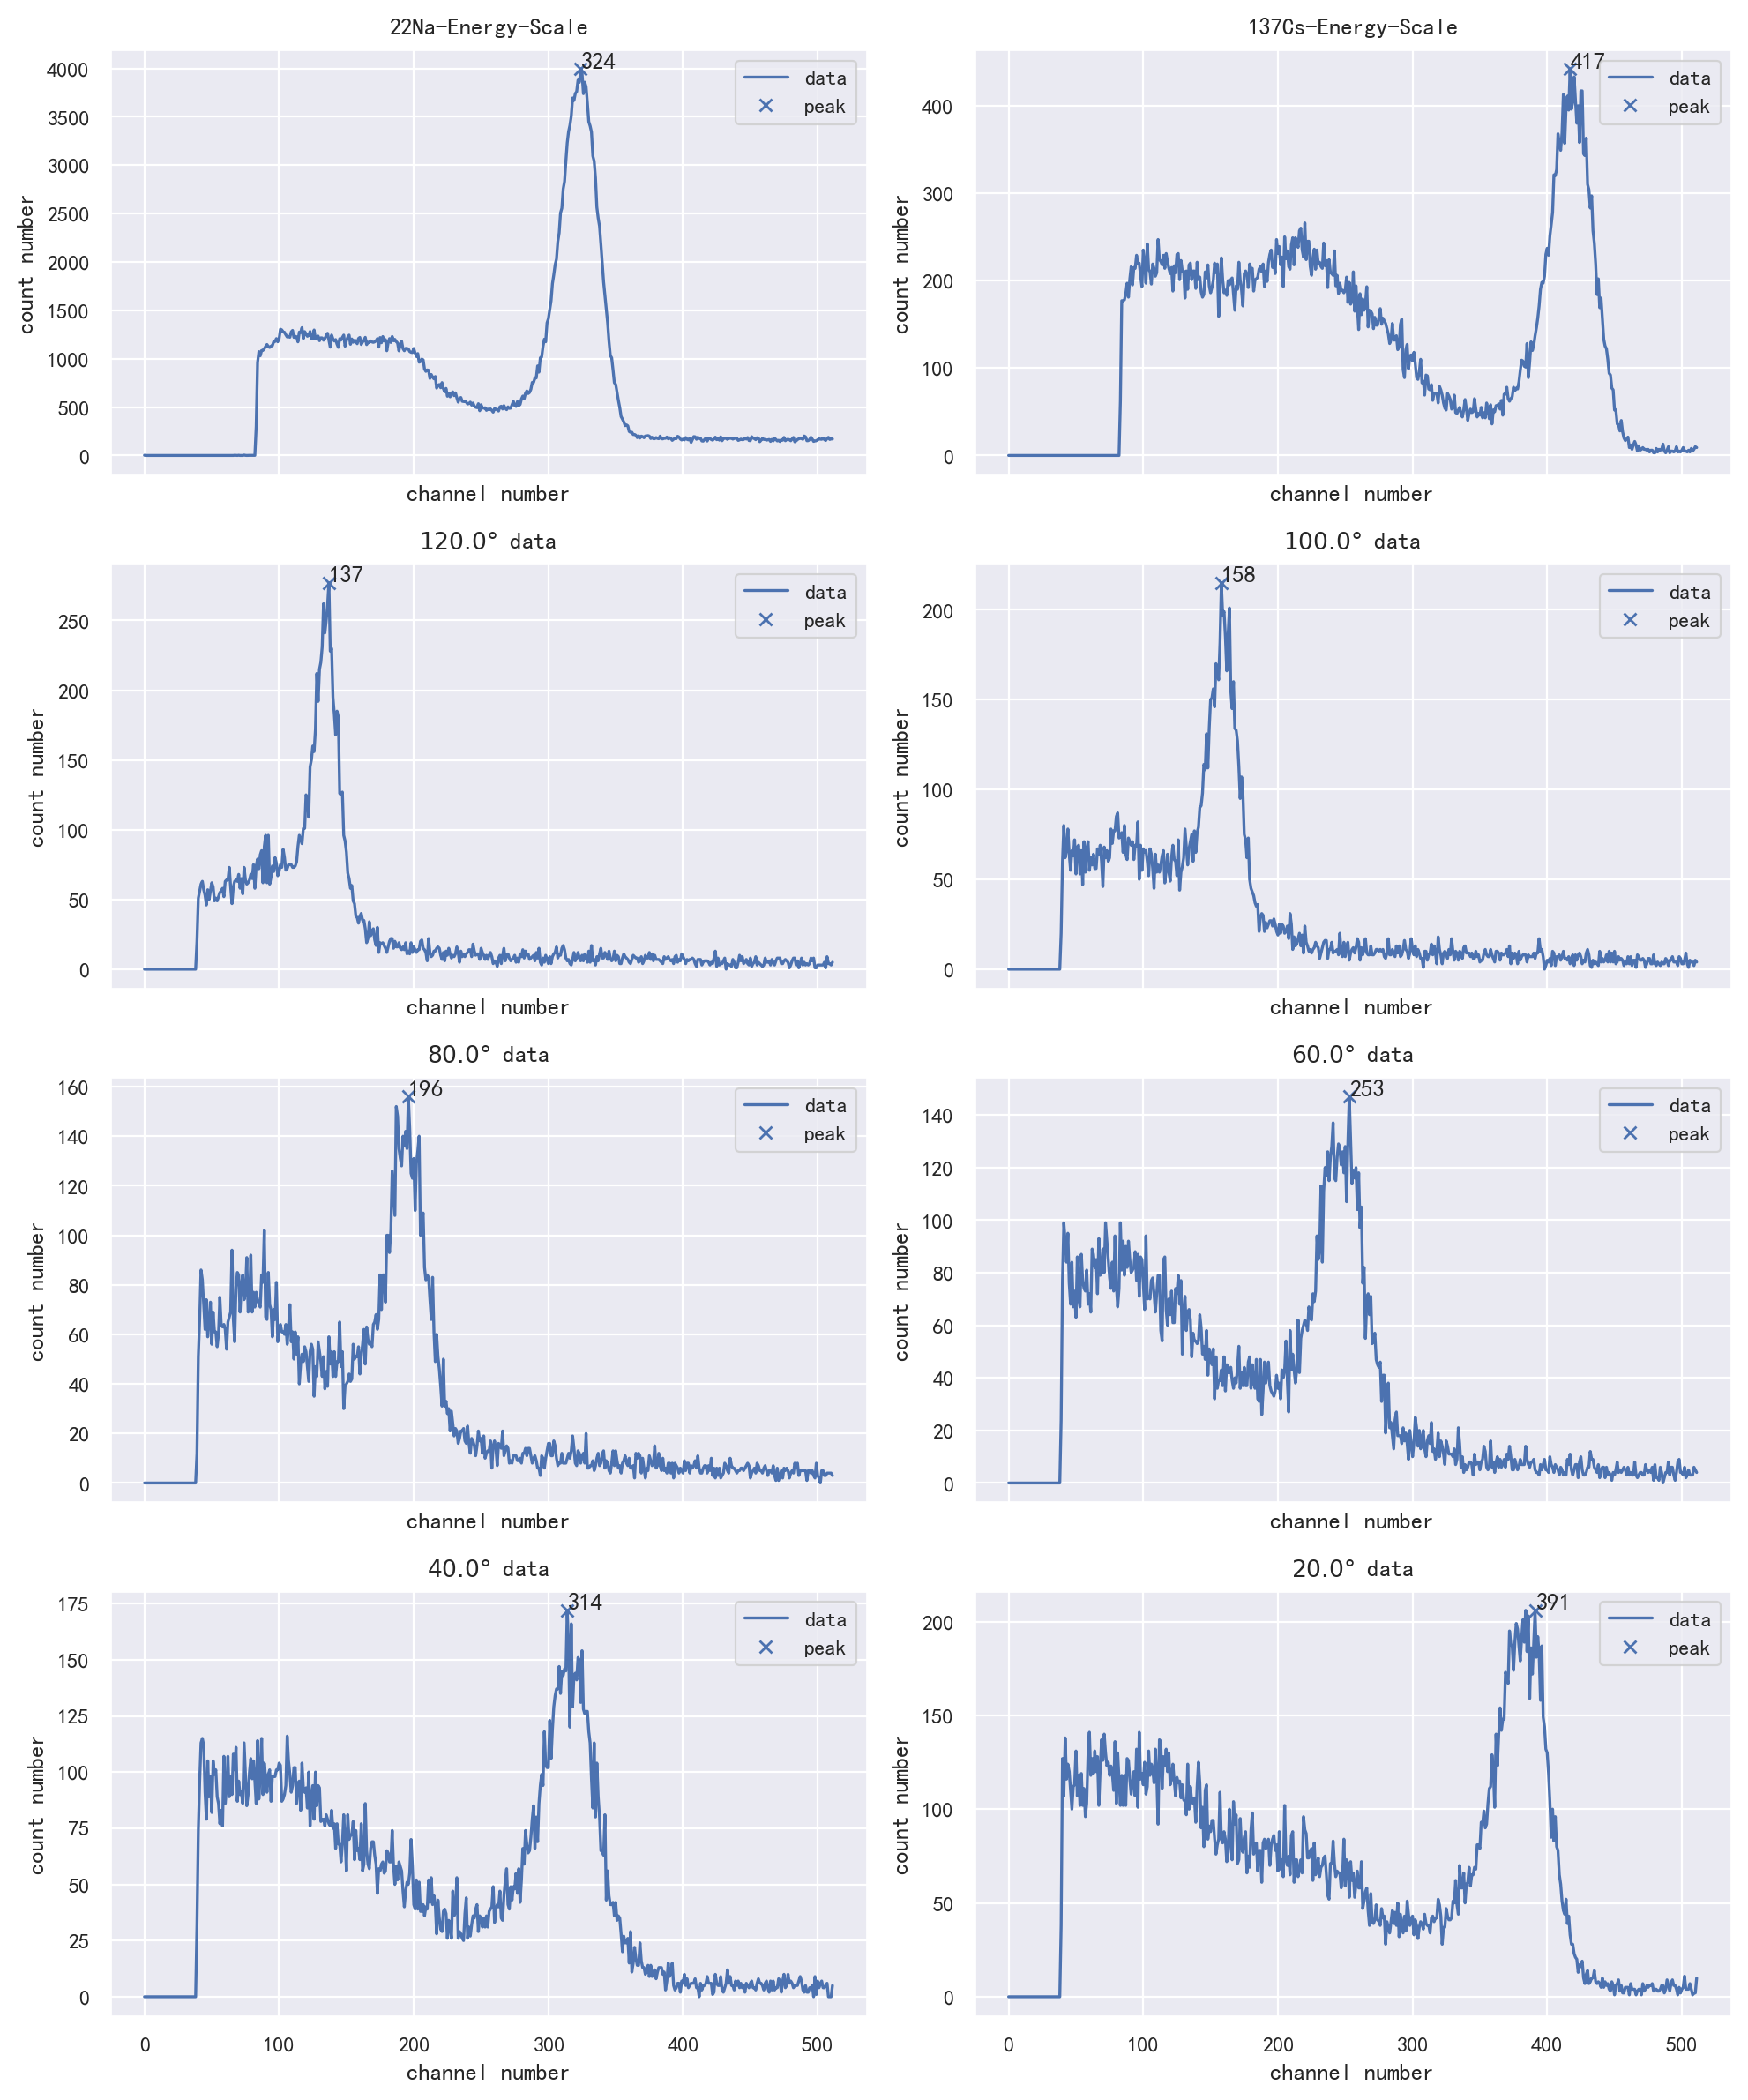

In [19]:
# pd.read_csv(txtfiles[0],sep=' ')
meanings = ['22Na-Energy-Scale','137Cs-Energy-Scale']+[fr'${i}\degree$ data' for i in np.linspace(120,20,6)]
datas = [pd.read_csv(datapath+file, sep='\t')['1'].values for file in txtfiles]
datas = dict(zip(meanings,datas))

figs_per_line = 2
total_fig,total_axs = plt.subplots(len(datas)//figs_per_line+int(bool(len(datas)%figs_per_line)),
                                   figs_per_line,
                                   figsize=(10,12),
                                   sharex='all')
total_axs = total_axs.flatten()
prominences = [1000] + [300] + [100]*5 + [200]
peakinfos = []
for i,(ax,data_name,prom) in enumerate(zip(total_axs,datas,prominences)):
    data = datas[data_name]
    peaks, info = find_peaks(data,prominence=prom,distance=100) 
    peakinfos.append((peaks,info))
    ax.plot(data,c='b',label='data')
    # bl = baseline(data,3)
    # ax.plot(bl,c='r',label='baseline')
    ax.plot(peaks,data[peaks], "x",label='peak')
    for peak in peaks:
        ax.text(peak,data[peak],f'{peak}')
    ax.legend()
    ax.set_title(data_name)
    ax.set_xlabel('channel number')
    ax.set_ylabel('count number')

for ax in total_axs[i+1:]:
    ax.axis('off')

total_fig.tight_layout()

# ummm

[8.06282387 7.80046096 9.7472368  6.35285392 4.52770618 0.91327317]%


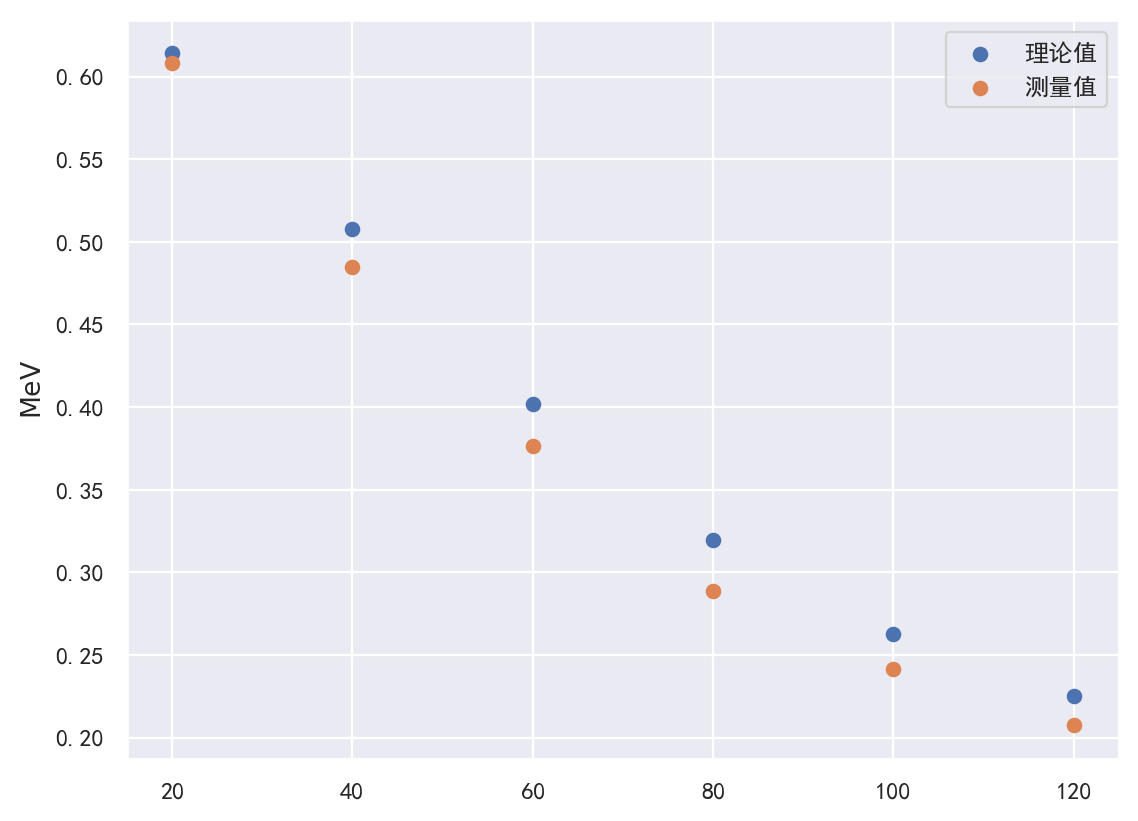

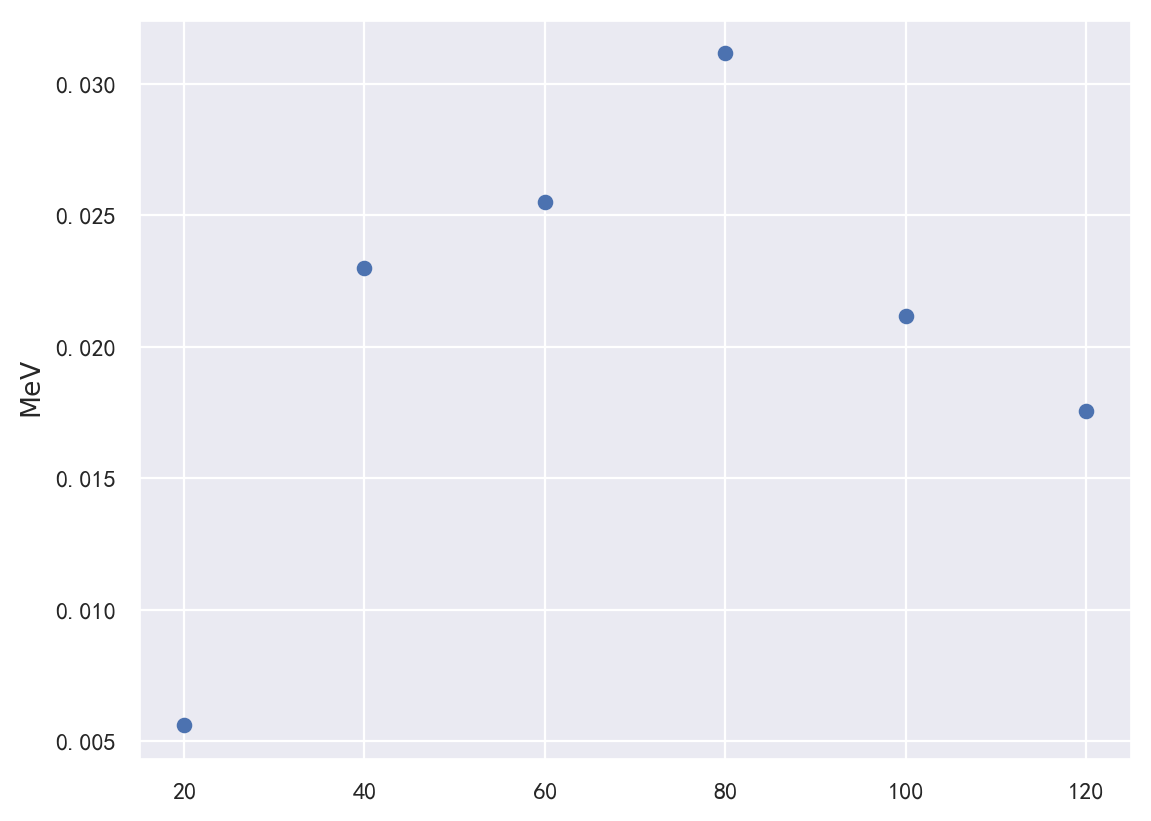

In [20]:
thetas = np.array([100,120,80,60,40,20])
daos = np.array([158,137,187,241,308,384])
theory_ene = gamma_out_ratio(thetas/180*np.pi,Cs137_Energy)*Cs137_Energy
measure_ene = dao_to_Ene(daos)*u.MeV
plt.scatter(thetas,theory_ene,label='理论值')
plt.scatter(thetas,measure_ene,label='测量值')
plt.legend()

error = np.abs(((theory_ene-measure_ene)/theory_ene).si.value)
print(error*100,end='%\n')
plt.show()
plt.scatter(thetas,theory_ene-measure_ene)
plt.show()

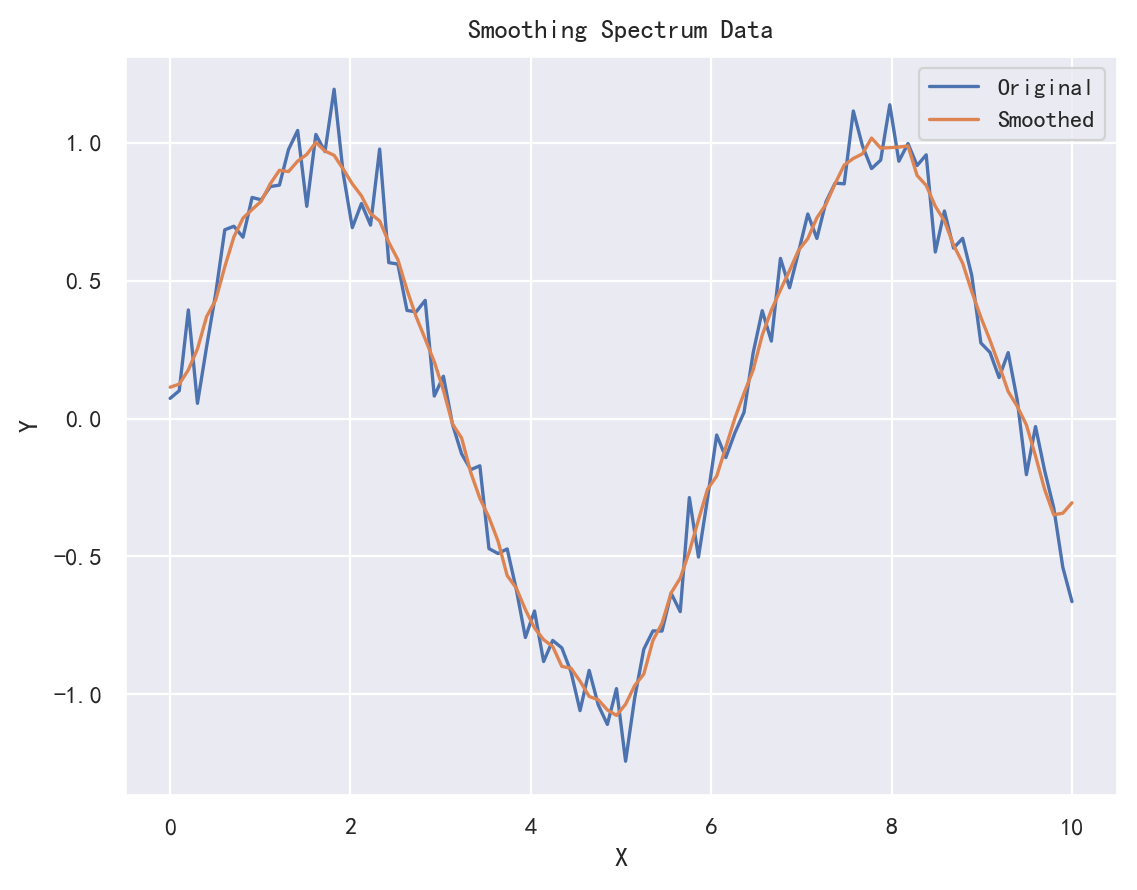

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这是原始的峰谱数据
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, size=100)

# 定义平滑窗口的大小
window_size = 5

# 定义平滑核，这里使用一个简单的移动平均滤波器
kernel = np.ones(window_size) / window_size

# 使用一维卷积对数据进行平滑处理
smoothed_y = np.convolve(y, kernel, mode='same')

# 绘制原始数据和平滑后的数据
plt.plot(x, y, label='Original')
plt.plot(x, smoothed_y, label='Smoothed')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Smoothing Spectrum Data')
plt.show()
